<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI 37 Capstone

<a id='part_iv'></a>
[Part I](Part_1-Imports#part_i) <br>
[Part II](Part-2_Cleaning_and_EDA#part_ii) <br>
[Part III](Part_3-EDA_2.ipynb#part_iii) <br>
[Part V](Part_5-Implementation.ipynb#part_v)

# Part IV: Modelling

<a id='part_iv'></a>

## Contents

[1. Imports (Libraries)](#imports)<br>
[2. Imports (Data)](#data_imports)<br>
[3. Train-Test-Split](#train_test_split)<br>
[4. Modelling](#modelling)<br>
[5. Pickling](#pickling)<br>



## 1. Imports (Libraries)

<a id='imports'></a>

In [8]:
# basic dependencies
import os
from time import process_time
import datetime as dt
import pandas as pd
import numpy as np
import csv

In [9]:
# basic visualisation
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import seaborn as sns

In [10]:
# Import imblearn libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [11]:
# Import sklearn libraries

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelBinarizer

import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from rgf.sklearn import RGFClassifier

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score


In [12]:
import pickle

In [13]:
import matplotlib.style as style
style.use('seaborn-v0_8')

In [14]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## 2. Imports (Data)

<a id='imports_data'></a>

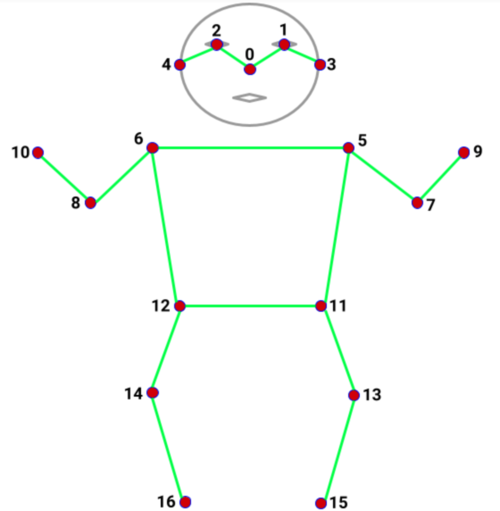

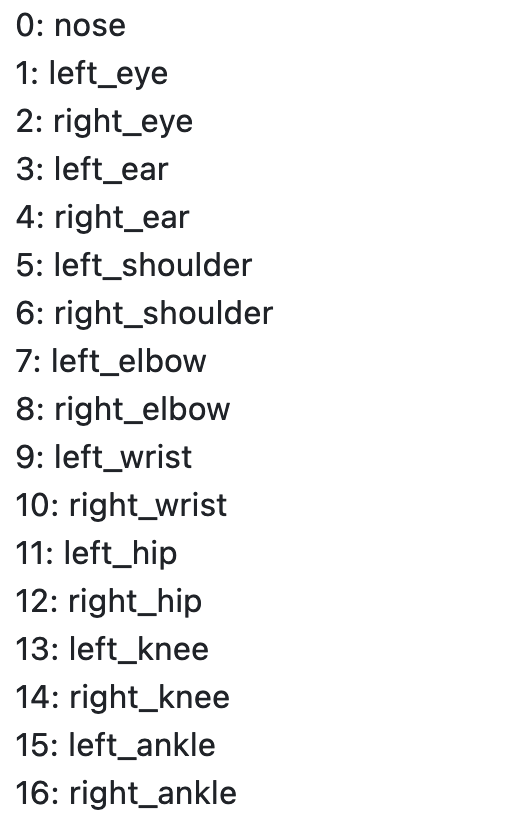

The csv file was created in [Part II](Part_2-Cleaning_and_EDA#part_ii)

There are a total of 60 columns. 

The first column is the class, of which there are only two options: jab or kick. 

The following 51 consist of 3 values for each of the 17 keypoints listed above. The three values, in order, are the normalised y co-ordinate, the normalised x co-ordinate, and the confidence of the keypoint. To be further explained in the data dictionary. To avoid repetition, I will only explain the x, y, and confidence values once. The naming convention for these 51 features are bodypart_x, bodypart_y, and bodypart_conf. For example for the nose: nose_x, nose_y, nose_conf. 

The last 8 columns are features that I created. See the data dictionary for more information.

#### Data dictionary:

|column| datatype|explanation|
|:-|:-:|:-|
|**class**|*string*| The name of the class. Pre-labelled based on the videos. Either `jab` or `kick`.|
|**bodypart_y**|*float*| The scaled y co-ordinate of the bodypart. The value is from 0 to 1.|
|**bodypart_x**|*float*| The scaled x co-ordinate of the bodypart. The value is from 0 to 1.|
|**bodypart_conf**|*float*| The confidence level of the keypoint. Meaning how confident MoveNet was that this is the actual location of the bodypart in question. The value is from 0 to 1.|
|**left_elbow_angle**|*float*| The angle of the left elbow, in degrees. Measured in relation to the left shoulder and wrist.|
|**left_hip_angle**|*float*| The angle of the left hip, in degrees. Measured in relation to the left shoulder and knee.|
|**left_knee_angle**|*float*| The angle of the left knee, in degrees. Measured in relation to the left hip and ankle.|
|**right_elbow_angle**|*float*| The angle of the right elbow, in degrees. Measured in relation to the right shoulder and wrist.|
|**right_hip_angle**|*float*| The angle of the right hip, in degrees. Measured in relation to the right shoulder and knee.|
|**right_knee_angle**|*float*| The angle of the right knee, in degrees. Measured in relation to the right hip and ankle.|
|**left_eye_left_wrist**|*float*| The scaled distance between the left eye and left wrist. The value is from 0 to 1.|
|**left_ankle_right_ankle**|*float*| The scaled distance between the left ankle and right ankle. The value is from 0 to 1.|

<br>


In [15]:
# Read coordinates csv file
df = pd.read_csv('../data/04-edited_csv/combined_coords2.csv')

## 3. Train-Test-Split

<a id='train_test_split'></a>

In [16]:
X = df.drop('class', axis=1) # Store the Features
y = df['class'] # Store the Target value (i.e. Class Name)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [18]:
y_test

5013      kick
6224      kick
7834      kick
1701       jab
5477      kick
         ...  
1446       jab
4407      kick
1020       jab
705        jab
10117    guard
Name: class, Length: 3796, dtype: object

## 4. Modelling

<a id='modelling'></a>

### Contents - Modelling
[A. Baseline Model - Logistic Regression](#baseline)<br>
[B. Random Forest](#rf)<br>
[C. Regularised Greedy Forest](#rgf)<br>
[D. AdaBoost](#ada)<br>
[E. Summary](#summary)<br>


[Back to top](#part_iv)

To reduce run time, the params have been changed to the best ones with the original options commented on the side.

In [35]:
# Logistic Regression
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('lr', LogisticRegression(solver='liblinear'))]

lr_pipe = Pipeline(steps)

lr_params = {'smote__sampling_strategy': ['minority'], #'all', 'auto', 'minority', 'not minority', 0.5, 1.0
             'lr__C': [5], #0.1, 0.5, 1, 5, 10
            'lr__penalty': ['l1']} #'l1', 'l2'

lr = GridSearchCV(lr_pipe, param_grid=lr_params, cv=5)


In [36]:
start = process_time()

In [37]:
lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'lr__C': [5], 'lr__penalty': ['l1'],
                         'smote__sampling_strategy': ['minority']})

In [38]:
end = process_time()
print(end-start)

67.827806


In [39]:
print(lr.cv_results_['mean_fit_time'])

[7.45794835]


In [45]:
lr.best_params_

{'lr__C': 5, 'lr__penalty': 'l1', 'smote__sampling_strategy': 'minority'}

In [46]:
# Making predictions
y_lr_pred = lr.predict(X_test)
y_lr_pred_proba = lr.predict_proba(X_test)

In [28]:
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(3796, 3)

In [50]:
pred_prob_train = lr.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train, 
                                multi_class="ovr", average="micro")
pred_prob_test = lr.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test, 
                                multi_class="ovr", average="micro")

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_lr_pred))

ROC-AUC on training set: 0.990764997651797
ROC-AUC on testing set: 0.9909577743084895
              precision    recall  f1-score   support

       guard       0.92      0.90      0.91      1242
         jab       0.95      0.93      0.94      1009
        kick       0.94      0.97      0.96      1545

    accuracy                           0.94      3796
   macro avg       0.94      0.94      0.94      3796
weighted avg       0.94      0.94      0.94      3796



### B - Random Forest

<a id='rf'></a>

In [40]:
# Random Forest
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('rf', RandomForestClassifier())]

rf_pipe = Pipeline(steps)

rf_params = {
    'smote__sampling_strategy': ['not minority'], #'all', 'auto', 'minority', 'not minority', 0.5, 1.0     
    'rf__n_estimators': [500 ], #50, 100, 200, 500 
    'rf__criterion': ['entropy'], #'gini','entropy', 'log_loss' 
    'rf__max_features': ['sqrt'], #'sqrt','log2' 
    'rf__random_state': [42]
}

rf = GridSearchCV(rf_pipe, param_grid=rf_params, cv=5)


In [41]:
start = process_time()

In [42]:
rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__criterion': ['entropy'],
                         'rf__max_features': ['sqrt'],
                         'rf__n_estimators': [500], 'rf__random_state': [42],
                         'smote__sampling_strategy': ['not minority']})

In [43]:
end = process_time()
print(end-start)

85.098437


In [56]:
print(rf.cv_results_['mean_fit_time'])

[ 1.03324151  2.03317828  4.06008296  9.93920341  0.83381052  1.64593897
  3.21225801  8.10966597  1.17832298  2.34477115  4.65145497 11.55860896
  0.95405378  1.87639713  3.73969359  9.22277489  1.18210068  2.34135861
  4.72098947 11.47212954  0.95130868  1.88306069  3.71156483  9.22942047]


In [57]:
rf.best_params_

{'rf__criterion': 'entropy',
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 500,
 'rf__random_state': 42,
 'smote__sampling_strategy': 'not minority'}

In [45]:
# Making predictions
y_rf_pred = rf.predict(X_test)
y_rf_pred_proba = rf.predict_proba(X_test)

In [46]:
pred_prob_train = rf.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train, 
                                multi_class="ovr", average="micro")
pred_prob_test = rf.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test, 
                                multi_class="ovr", average="micro")

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_rf_pred))

ROC-AUC on training set: 0.9999999999999999
ROC-AUC on testing set: 0.9999302549075562
              precision    recall  f1-score   support

       guard       1.00      1.00      1.00      1242
         jab       1.00      1.00      1.00      1009
        kick       1.00      1.00      1.00      1545

    accuracy                           1.00      3796
   macro avg       1.00      1.00      1.00      3796
weighted avg       1.00      1.00      1.00      3796



### C - Regularised Greedy Forest

<a id='rgf'></a>

In [47]:
# Regularised Greedy Forest
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('rgf', RGFClassifier())]

rgf_pipe = Pipeline(steps)

rgf_params = {
    'smote__sampling_strategy': ['not minority'], #'all', 'auto', 'minority', 'not minority', 0.5, 1.0       
    'rgf__n_iter': [None],
    'rgf__l2': [0.1],
    'rgf__sl2': [0.07],
    'rgf__learning_rate': [0.8], # 0.8,1.0,1.2
    'rgf__max_leaf': [1000] # 800,1000
}

rgf = GridSearchCV(rgf_pipe, param_grid=rgf_params, cv=5)


In [48]:
start = process_time()

In [49]:
rgf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('rgf', RGFClassifier())]),
             param_grid={'rgf__l2': [0.1], 'rgf__learning_rate': [0.8],
                         'rgf__max_leaf': [1000], 'rgf__n_iter': [None],
                         'rgf__sl2': [0.07],
                         'smote__sampling_strategy': ['not minority']})

In [50]:
end = process_time()
print(end-start)

21.50333900000001


In [51]:
print(rgf.cv_results_['mean_fit_time'])

[7.02453618]


In [24]:
rgf.best_params_

{'rgf__l2': 0.1,
 'rgf__learning_rate': 0.8,
 'rgf__max_leaf': 1000,
 'rgf__n_iter': None,
 'rgf__sl2': 0.07,
 'smote__sampling_strategy': 'not minority'}

In [25]:
# Making predictions
y_rgf_pred = rgf.predict(X_test)
y_rgf_pred_proba = rgf.predict_proba(X_test)

In [52]:
pred_prob_train = rgf.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train, 
                                multi_class="ovr", average="micro")
pred_prob_test = rgf.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test, 
                                multi_class="ovr", average="micro")

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_rgf_pred))

ROC-AUC on training set: 0.99995047890268
ROC-AUC on testing set: 0.999878830914023
              precision    recall  f1-score   support

       guard       0.99      0.99      0.99      1242
         jab       0.99      0.99      0.99      1009
        kick       1.00      0.99      1.00      1545

    accuracy                           0.99      3796
   macro avg       0.99      0.99      0.99      3796
weighted avg       0.99      0.99      0.99      3796



### D - AdaBoost

<a id='ada'></a>

In [53]:
# AdaBoost
steps = [['smote', SMOTE(random_state = 42)],
         ('ss', StandardScaler()),
        ('ada', AdaBoostClassifier())]

ada_pipe = Pipeline(steps)

ada_params = {
    'smote__sampling_strategy': ['not minority'], # 'all', 'auto', 'minority', 'not minority', 0.5, 1.0     
    'ada__learning_rate': [0.5], # 0.5, 1, 2, 5, 10 
    'ada__n_estimators': [100], # 3, 5, 10, 25, 50, 100 
    'ada__random_state': [42]
}

ada = GridSearchCV(ada_pipe, param_grid=ada_params, cv=5)


In [54]:
start = process_time()

In [55]:
ada.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[['smote', SMOTE(random_state=42)],
                                       ('ss', StandardScaler()),
                                       ('ada', AdaBoostClassifier())]),
             param_grid={'ada__learning_rate': [0.5],
                         'ada__n_estimators': [100], 'ada__random_state': [42],
                         'smote__sampling_strategy': ['not minority']})

In [56]:
end = process_time()
print(end-start)

40.63663299999999


In [57]:
print(ada.cv_results_['mean_fit_time'])

[4.23219519]


In [84]:
ada.best_params_

{'ada__learning_rate': 0.5,
 'ada__n_estimators': 100,
 'ada__random_state': 42,
 'smote__sampling_strategy': 'not minority'}

In [58]:
# Making predictions
y_ada_pred = ada.predict(X_test)
y_ada_pred_proba = ada.predict_proba(X_test)

In [59]:
pred_prob_train = ada.predict_proba(X_train)
auc_score_train = roc_auc_score(y_train, pred_prob_train, 
                                multi_class="ovr", average="micro")
pred_prob_test = ada.predict_proba(X_test)
auc_score_test = roc_auc_score(y_test, pred_prob_test, 
                                multi_class="ovr", average="micro")

print(f'ROC-AUC on training set: {auc_score_train}')
print(f'ROC-AUC on testing set: {auc_score_test}')


print(classification_report(y_test, y_ada_pred))

ROC-AUC on training set: 0.9893852745835169
ROC-AUC on testing set: 0.9903286458154055
              precision    recall  f1-score   support

       guard       1.00      0.69      0.81      1242
         jab       0.80      0.99      0.88      1009
        kick       0.91      1.00      0.95      1545

    accuracy                           0.89      3796
   macro avg       0.90      0.89      0.88      3796
weighted avg       0.91      0.89      0.89      3796



### E - Summary

<a id='summary'></a>

|Model|Train roc_auc Score|Test roc_auc Score| Run Time (seconds)|
|:-|:-:|:-:|:-:|
|Logistic Regression|0.99|0.99|67.8|
|Random Forest|1.00|1.00|85.1|
|**Regularised Greedy Forest**|1.00|1.00|**21.5**|
|AdaBoost|0.99|0.99|40.6|



Because the MoveNet model is already so well trained on both COCO and the internal Google Active dataset, all the models unsurprisingly scored extremely highly. I ultimately chose the baseline Regularised Greedy Forest model because it was the fastest of all my models. 

### F - Visualisations of Best Model

<a id='viz'></a>

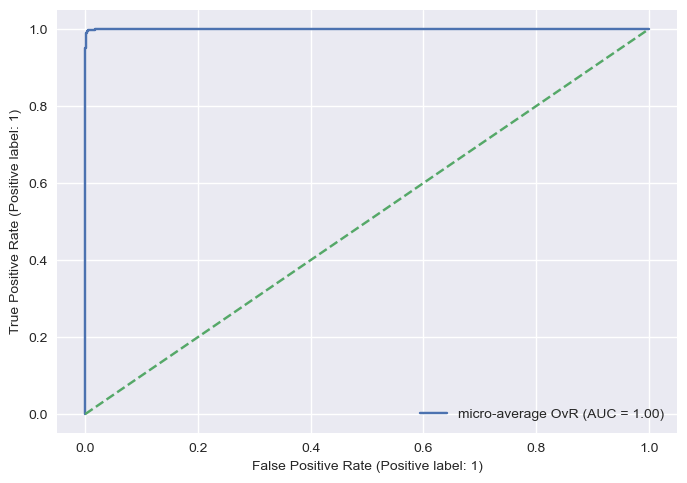

In [30]:
roc_display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_rgf_pred_proba.ravel(),
    name="micro-average OvR"
)


plt.plot([0,1],[0,1],label='baseline',linestyle='--')
plt.savefig('rocauc.png', transparent = True)

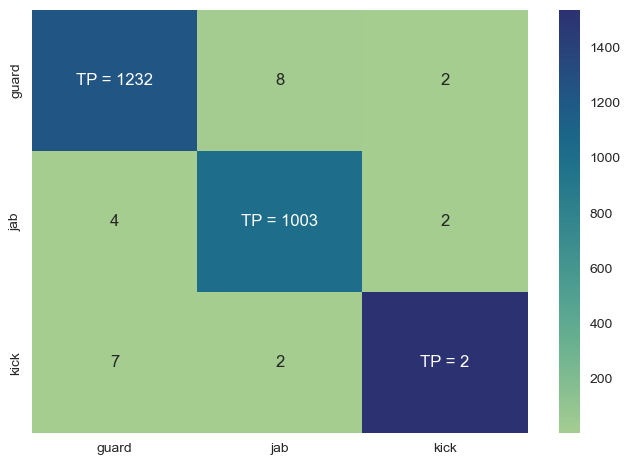

In [31]:
# plot confusion matrix heatmap
cm = confusion_matrix(y_test,rgf.predict(X_test))
cm_label = []
for index, value in enumerate(cm):
    if index == 0:
        cm_label.append(['TP = ' + str(value[0]), str(value[1]), str(value[2])])
    elif index == 1:
        cm_label.append([str(value[0]), 'TP = ' + str(value[1]), str(value[2])])
    else:
        cm_label.append([str(value[0]), str(value[1]), 'TP = ' + str(value[1])])
        
sns.heatmap(
    cm,
    annot=np.array(cm_label),
    annot_kws={'fontsize': 12},
    fmt='',
    cmap='crest',
    xticklabels=label_binarizer.classes_,
    yticklabels=label_binarizer.classes_
)

plt.savefig('cm.png', transparent = True)

In [33]:
coef = rgf.best_estimator_['rgf'].feature_importances_
feature = rgf.best_estimator_['ss'].get_feature_names_out()

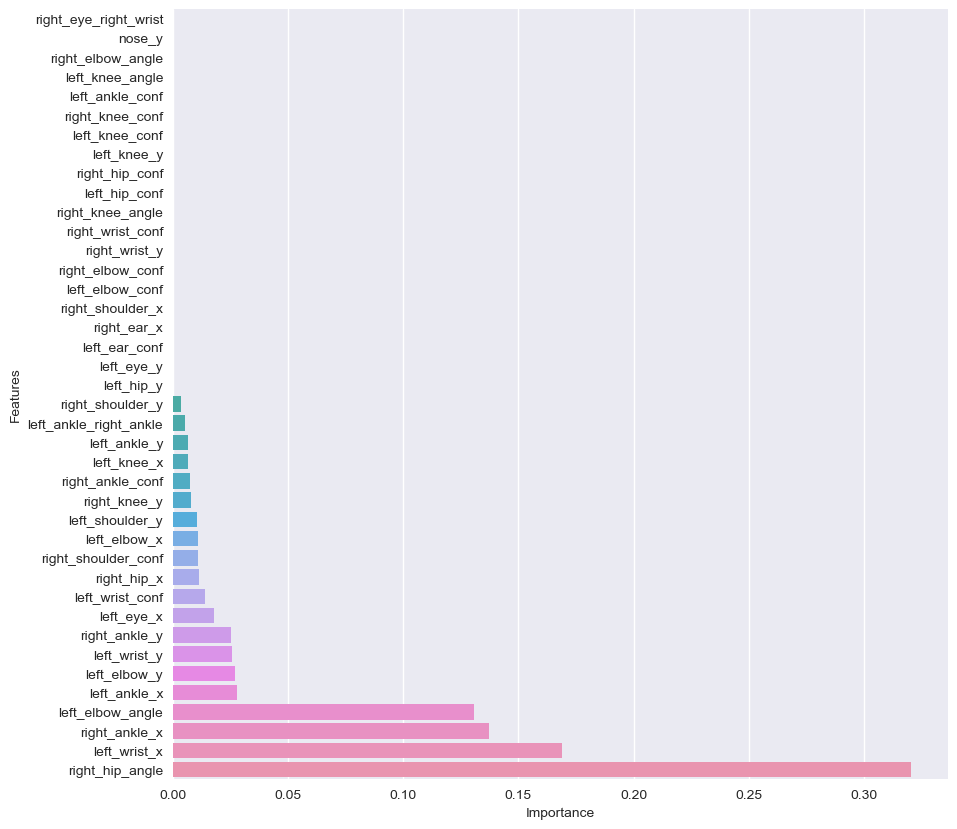

In [34]:
# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Features': feature, 'Importance': coef})

# Select the top 20 and bottom 20 features
top_features = feature_importance.nlargest(20, 'Importance')
bottom_features = feature_importance.nsmallest(20, 'Importance')

# Concatenate the top and bottom features
selected_features = pd.concat([top_features, bottom_features])

# Sort the features by importance
selected_features = selected_features.sort_values('Importance', ascending=True)

fig, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=selected_features.sort_values(by='Importance'), x='Importance',y='Features',
            orient='h', ax=axes)

plt.savefig('features.png', transparent = True)

[Back to top of modelling section](#modelling)

[Back to top](#part_iv)

## 5. Pickling

<a id='pickling'></a>

In [87]:
with open('../data/06-pickle/rgf_muaythai2.pkl', 'wb') as f:
    pickle.dump(rgf, f)

## <b> End of Part IV</b> <br>

[Part I](Part_1-Cleaning.ipynb#part_i)<br>
[Part II](Part_2-Cleaning_and_EDA.ipynb#part_ii) <br>
[Part III](Part_3-Modelling.ipynb#part_iii) <br>
[Part V](Part_5-Implementation.ipynb#part_v)